<a href="https://colab.research.google.com/github/Praneesh-Sharma/Deep-Learning-Practice/blob/main/NLP/Improving_Performance_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving the performance of the Text Classifier with CNN

This notebook covers tries to explore the CNN model by replacing the LSTM model implemented in the previous video. We'll compare the accuracy and loss for a CNN model on the same headlines data.

In [8]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.12.0


## Downloading the headlines data



In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/wdd-2-node.appspot.com/x1.json \
    -o /tmp/headlines.json

In [10]:
import pandas as pd

data = pd.read_json("./x1.json")
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [11]:
##create arrays to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

In [12]:
##define tokenizing and padding parameters
vocab_size = 10000
max_length = 100
embedding_dim = 64
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [13]:
##training set from 0 to training size
training_sentences = headlines[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = headlines[training_size:]
testing_labels = labels[training_size:]

In [14]:
##train the tokenizer on training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

##create training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

##create test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Define the neural network model with the following layers:
1. Embedding layer
2. Replace the bidirectional LSTM layers with convolutional layers with a filter size of 5.
3. GlovalAveragePooling Layer to down sample the feature map.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation 

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            20544     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 662,129
Trainable params: 662,129
Non-trainable params: 0
__________________________________________________

In [18]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
625/625 - 26s - loss: 0.4740 - accuracy: 0.7594 - val_loss: 0.3664 - val_accuracy: 0.8328 - 26s/epoch - 42ms/step
Epoch 2/10
625/625 - 16s - loss: 0.2599 - accuracy: 0.8946 - val_loss: 0.3468 - val_accuracy: 0.8485 - 16s/epoch - 26ms/step
Epoch 3/10
625/625 - 16s - loss: 0.1764 - accuracy: 0.9337 - val_loss: 0.3778 - val_accuracy: 0.8444 - 16s/epoch - 26ms/step
Epoch 4/10
625/625 - 17s - loss: 0.1183 - accuracy: 0.9578 - val_loss: 0.4597 - val_accuracy: 0.8404 - 17s/epoch - 27ms/step
Epoch 5/10
625/625 - 16s - loss: 0.0754 - accuracy: 0.9760 - val_loss: 0.5178 - val_accuracy: 0.8392 - 16s/epoch - 26ms/step
Epoch 6/10
625/625 - 17s - loss: 0.0464 - accuracy: 0.9870 - val_loss: 0.6204 - val_accuracy: 0.8347 - 17s/epoch - 27ms/step
Epoch 7/10
625/625 - 17s - loss: 0.0255 - accuracy: 0.9932 - val_loss: 0.7745 - val_accuracy: 0.8301 - 17s/epoch - 27ms/step
Epoch 8/10
625/625 - 17s - loss: 0.0131 - accuracy: 0.9972 - val_loss: 0.8790 - val_accuracy: 0.8300 - 17s/epoch - 27ms/step


## Visualize the accuracy and loss

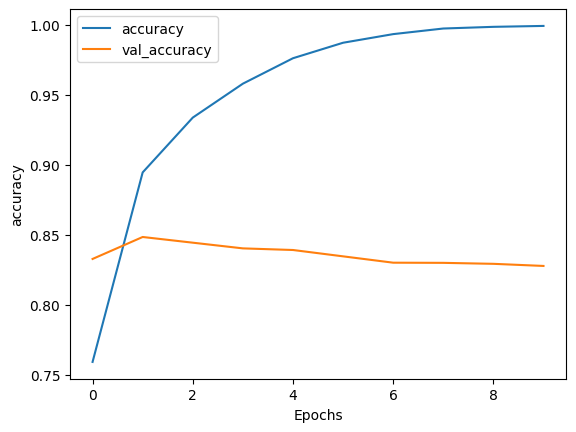

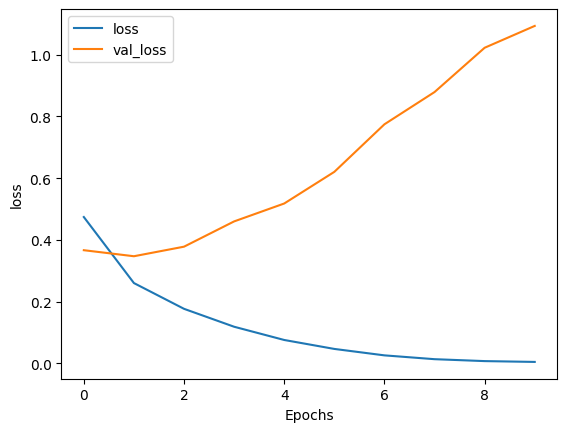

In [19]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Classifying new sentences

In [20]:
sentence = ["the girl starting to fear snakes in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 110ms/step
[[6.1917322e-05]
 [5.1003906e-07]]
